# Problem 3

**Dataset Source:** "https://raw.githubusercontent.com/Edward-Koh/CS210-p2/refs/heads/main/netflix_titles.csv"
**Description:** Netflix movies and TV shows dataset with ~8000 rows.

**Loading Data**

In [25]:

import pandas as pd

url = "https://raw.githubusercontent.com/Edward-Koh/CS210-p2/refs/heads/main/netflix_titles.csv"
df = pd.read_csv("netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [26]:
def handle_missing_values(df):

    missing_rows = df[df.isna().any(axis=1)]
    print("Rows with missing values:")
    print(missing_rows)


    for col in df.columns:
        if df[col].dtype == 'object':   # categorical column

            df[col] = df[col].fillna("Unknown")
        else:   #numerical column

            df[col] = df[col].fillna(df[col].median())

    return df


df = handle_missing_values(df)

Rows with missing values:
     show_id     type                  title         director  \
0         s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show          Blood & Water              NaN   
2         s3  TV Show              Ganglands  Julien Leclercq   
3         s4  TV Show  Jailbirds New Orleans              NaN   
4         s5  TV Show           Kota Factory              NaN   
...      ...      ...                    ...              ...   
8795   s8796  TV Show        Yu-Gi-Oh! Arc-V              NaN   
8796   s8797  TV Show             Yunus Emre              NaN   
8797   s8798  TV Show              Zak Storm              NaN   
8800   s8801  TV Show     Zindagi Gulzar Hai              NaN   
8803   s8804  TV Show            Zombie Dumb              NaN   

                                                   cast  \
0                                                   NaN   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   
2     Sami Bouaj

In [27]:
def remove_duplicates(df):

    duplicates = df[df.duplicated()]
    
    if not duplicates.empty:
        print("Duplicate rows found:")
        print(duplicates)
    else:
        print("No duplicates found in dataset. Demonstrating with example:")

        example = pd.DataFrame({
            "title": ["Movie A", "Movie B", "Movie B", "Movie C"],
            "type": ["Movie", "TV Show", "TV Show", "Movie"]
        })
        print("Example duplicates:")
        print(example[example.duplicated()])
        print("Example after removing duplicates:")
        print(example.drop_duplicates())
    
    df_cleaned = df.drop_duplicates()
    
    return df_cleaned

df = remove_duplicates(df)

No duplicates found in dataset. Demonstrating with example:
Example duplicates:
     title     type
2  Movie B  TV Show
Example after removing duplicates:
     title     type
0  Movie A    Movie
1  Movie B  TV Show
3  Movie C    Movie


In [28]:
def handle_invalid_duration(df):

    df['duration_min'] = df['duration'].str.extract(r'(\d+)\s*min')[0].astype(float)

    df['num_seasons'] = df['duration'].str.extract(r'(\d+\s*Season[s]?)')[0]

    print("Sample of split duration columns:")
    print(df[['duration', 'duration_min', 'num_seasons']].head(10))

    return df

df = handle_invalid_duration(df)


Sample of split duration columns:
    duration  duration_min num_seasons
0     90 min          90.0         NaN
1  2 Seasons           NaN   2 Seasons
2   1 Season           NaN    1 Season
3   1 Season           NaN    1 Season
4  2 Seasons           NaN   2 Seasons
5   1 Season           NaN    1 Season
6     91 min          91.0         NaN
7    125 min         125.0         NaN
8  9 Seasons           NaN   9 Seasons
9    104 min         104.0         NaN


In [29]:
def handle_outliers(df):
    if 'release_year' in df.columns:

        q1 = df['release_year'].quantile(0.25)
        q3 = df['release_year'].quantile(0.75)
        iqr = q3 - q1

        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        outliers = df[(df['release_year'] < lower) | (df['release_year'] > upper)]
        if not outliers.empty:
            print("Outlier rows in 'release_year':")
            print(outliers)
        else:
            print("No outliers found. Demonstrating with example:")
            example = pd.DataFrame({
                "title": ["Movie A", "Movie B", "Movie C", "Movie D"],
                "release_year": [1999, 2020, 1800, 3000]
            })
            print("Outlier example rows:")
            print(example[(example['release_year'] < 1990) | (example['release_year'] > 2023)])
            print("Example after removing outliers:")
            print(example[(example['release_year'] >= 1990) & (example['release_year'] <= 2023)])

        df_cleaned = df[(df['release_year'] >= lower) & (df['release_year'] <= upper)]
        return df_cleaned
    
    else:
        print("Column 'release_year' not in dataset.")
        return df

df = handle_outliers(df)

Outlier rows in 'release_year':
     show_id   type              title          director  \
7         s8  Movie            Sankofa      Haile Gerima   
22       s23  Movie    Avvai Shanmughi    K.S. Ravikumar   
24       s25  Movie              Jeans        S. Shankar   
26       s27  Movie     Minsara Kanavu       Rajiv Menon   
41       s42  Movie               Jaws  Steven Spielberg   
...      ...    ...                ...               ...   
8764   s8765  Movie         Wyatt Earp   Lawrence Kasdan   
8766   s8767  Movie                XXx         Rob Cohen   
8768   s8769  Movie  Y Tu Mamá También    Alfonso Cuarón   
8770   s8771  Movie            Yaadein      Subhash Ghai   
8792   s8793  Movie        Young Tiger            Mu Chu   

                                                   cast  \
7     Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...   
22    Kamal Hassan, Meena, Gemini Ganesan, Heera Raj...   
24    Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...   
26    Arvin

In [30]:
def standardize_categorical(df):
    if 'type' in df.columns:
        # Standardize text
        df['type'] = df['type'].str.strip().str.title()
        print("Sample of standardized 'type' column:")
        print(df['type'].head(10))
    else:
        print("Column 'type' not in dataset. Demonstrating with example:")
        example = pd.DataFrame({
            "type": ["movie", " MOVIE", "tv show", "TV Show", "Tv show "]
        })
        print("Before standardization:")
        print(example)
        example['type'] = example['type'].str.strip().str.title()
        print("After standardization:")
        print(example)
    
    return df

df = standardize_categorical(df)

Sample of standardized 'type' column:
0       Movie
1     Tv Show
2     Tv Show
3     Tv Show
4     Tv Show
5     Tv Show
6       Movie
8     Tv Show
9       Movie
10    Tv Show
Name: type, dtype: object


### Preprocessing Summary

**Issues present in the Netflix dataset:**

1. **Missing values** – Present in director, cast, country, and rating` columns.  
   
   Fix: Dropped all rows containing missing values using dropna().

2. **Outliers** – Some extreme release_year values were outside the normal range.  
   
   Fix: Removed outliers using the IQR method.

3. **Invalid values** – Two different data types in duration column (minutes and seasons).
   
   Fix: Split the two values (minutes and seasons) into different columns

4. **Categorical/text inconsistencies** – type column had inconsistent casing and extra spaces.  
   
   Fix: Standardized by stripping whitespace and applying title case.
   

**Issues not present in the dataset:**

1. **Duplicate rows** - No exact duplicates were found.  

   *Made-up example: A small 4-row dataframe with duplicates was created to demonstrate the function.


**ANALYSIS**

In [31]:
# Top-N within each group
# Top 3 countries for each type (Movie or TV Show) by most recent release_year
top_n = 3
top_countries = df[df['release_year'].notna()].sort_values(['type','release_year'], ascending=[True,False])
top_countries = top_countries.groupby('type').head(top_n)[['type','country','title','release_year']]
top_countries


,type,country,title,release_year
6,Movie,Unknown,My Little Pony: A New Generation,2021
9,Movie,United States,The Starling,2021
12,Movie,"Germany, Czech Republic",Je Suis Karl,2021
1,Tv Show,South Africa,Blood & Water,2021
2,Tv Show,Unknown,Ganglands,2021
3,Tv Show,Unknown,Jailbirds New Orleans,2021


In [32]:
# Bin comparison
# Only Movies
movies_df = df[df['type'] == 'Movie'].copy()

# Create year bins
bins = [1900, 2000, 2015, 2023]
labels = ['Early', 'Middle', 'Recent']
movies_df['year_bin'] = pd.cut(movies_df['release_year'], bins=bins, labels=labels)

# Average duration per bin
avg_duration_per_bin = movies_df.groupby('year_bin', observed=False)['duration_min'].mean()
avg_duration_per_bin



year_bin
Early            NaN
Middle    103.319400
Recent     94.863737
Name: duration_min, dtype: float64

In [33]:
# Conditional aggregation
# Filter for Movies, group by rating, compute average release_year
avg_release_by_rating = df[df['type'] == 'Movie'].groupby('rating')['release_year'].mean()
avg_release_by_rating

rating
66 min      2015.000000
74 min      2017.000000
84 min      2010.000000
G           2011.619048
NC-17       2015.000000
NR          2013.955882
PG          2013.783784
PG-13       2013.192612
R           2014.687107
TV-14       2015.674491
TV-G        2017.508197
TV-MA       2016.946680
TV-PG       2015.877551
TV-Y        2017.430769
TV-Y7       2015.753623
TV-Y7-FV    2015.000000
UR          2012.000000
Unknown     2016.000000
Name: release_year, dtype: float64

In [34]:
# Percentage Distribution
# Percentage of total duration per type
percentage_duration = df.groupby('type')['duration_min'].sum().apply(
    lambda x: x / df['duration_min'].sum() * 100
)
percentage_duration


type
Movie      100.0
Tv Show      0.0
Name: duration_min, dtype: float64

In [35]:
# Most frequent value by group
# Group by 'type' and find the most frequent 'rating' for each
most_freq_rating = df.groupby('type')['rating'].agg(
    lambda x: x.value_counts().idxmax()  # most frequent
)
# Also get the count of that value
most_freq_count = df.groupby('type')['rating'].agg(
    lambda x: x.value_counts().max()  # count of most frequent
)

# Combine into a single dataframe
most_freq_df = pd.DataFrame({
    'Most Frequent Rating': most_freq_rating,
    'Count': most_freq_count
})

most_freq_df


,Most Frequent Rating,Count
type,,
Movie,TV-MA,1988
Tv Show,TV-MA,1137


**Visualization**

In [36]:
#imports
import matplotlib.pyplot as plt
import seaborn as sns

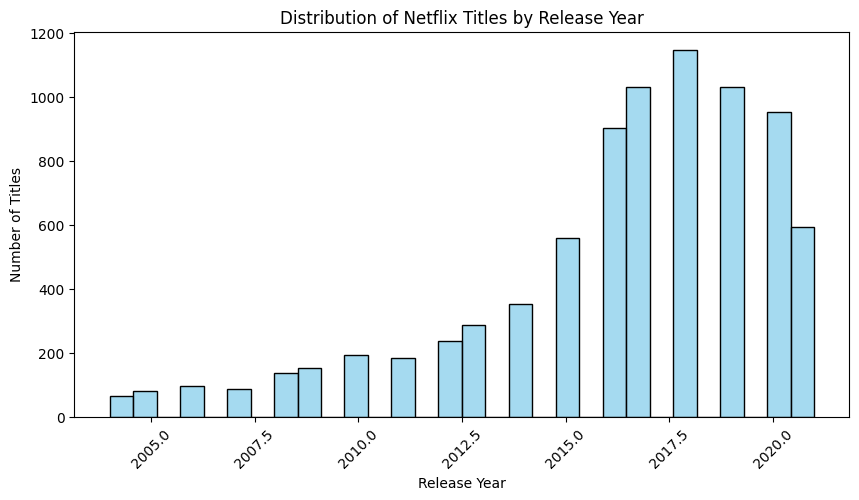

In [37]:
# Histogram

plt.figure(figsize=(10,5))
sns.histplot(df['release_year'], bins=30, kde=False, color='skyblue')
plt.title('Distribution of Netflix Titles by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.xticks(rotation=45)
plt.show()

The histogram shows that most Netflix titles were released after 2000, with a peak around 2015–2020.

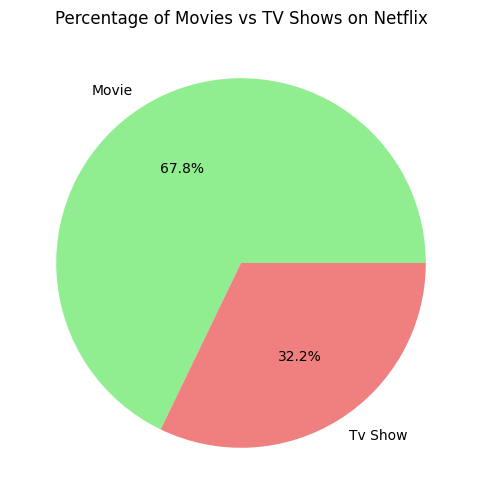

In [38]:
plt.figure(figsize=(6,6))
df['type'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightgreen','lightcoral'])
plt.title('Percentage of Movies vs TV Shows on Netflix')
plt.ylabel('')
plt.show()


The pie chart shows that Netflix has more Movies than Tv Shows

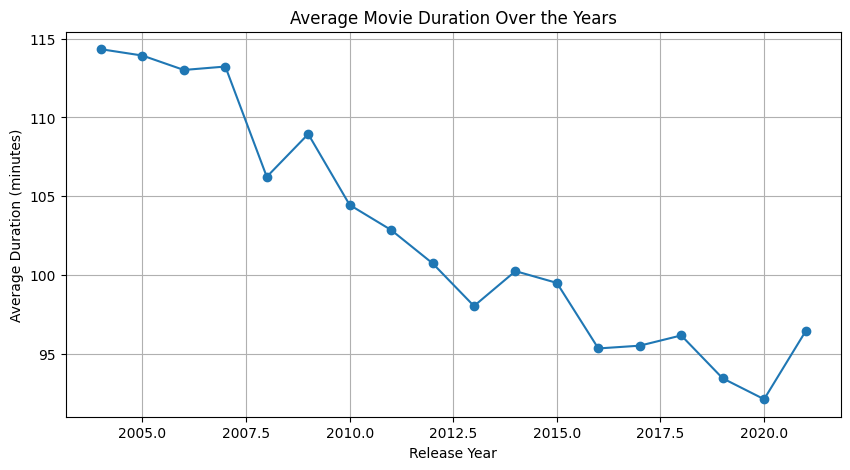

In [39]:
avg_duration_per_year = df[df['type'] == 'Movie'].groupby('release_year')['duration_min'].mean()

plt.figure(figsize=(10,5))
plt.plot(avg_duration_per_year.index, avg_duration_per_year.values, marker='o')
plt.title('Average Movie Duration Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Average Duration (minutes)')
plt.grid(True)
plt.show()


Shows the average movie duration over the years. As we can see the average duration is decreasing.


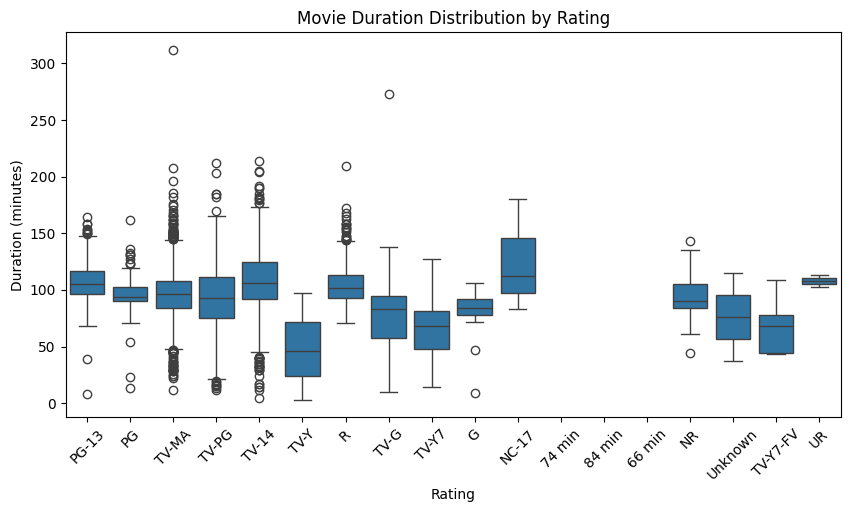

In [40]:
plt.figure(figsize = (10,5))
sns.boxplot(data = df[df['type'] == 'Movie'], x = 'rating', y = 'duration_min')
plt.title('Movie Duration Distribution by Rating')
plt.xlabel('Rating')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()


Shows the movie duration by their rating.

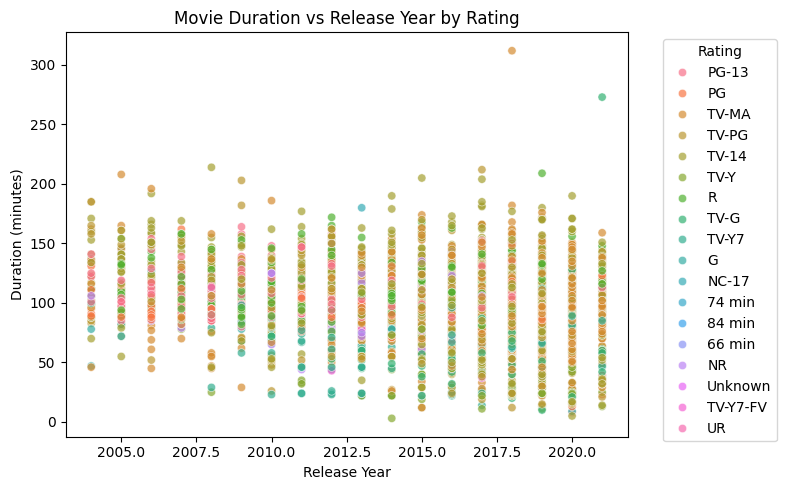

In [41]:
# Scatter plot for Movies only
movies = df[df['type'] == 'Movie']

plt.figure(figsize=(8,5))
sns.scatterplot(data=movies, x='release_year', y='duration_min', hue='rating', alpha=0.7)
plt.title('Movie Duration vs Release Year by Rating')
plt.xlabel('Release Year')
plt.ylabel('Duration (minutes)')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Shows how movie durations vary over the years and highlights trends by rating category.

In [42]:
# adding the cleaned data
df.to_csv("diy_dataset.csv", index=False)